## Code Definitions

- **Constituency Code**: Unique identifier for each Westminster Parliamentary constituency.(573 Constituencies)
- **Age**:
  - 1: Aged 16 to 24 years
  - 2: Aged 25 to 34 years
  - 3: Aged 35 to 49 years
  - 4: Aged 50 to 64 years
  - 5: Aged 65 years and over
- **Education**
  - 1: No qualifications - Individuals who have not obtained any formal educational qualifications.
  - 2: Basic Education - Includes basic schooling and lower secondary education qualifications, such as elementary level GCSEs, basic skills certifications, and entry-level vocational qualifications.
  - 3: Secondary Education - Encompasses completion of upper secondary education, signified by a larger number of GCSEs at higher grades, A levels, and intermediate vocational qualifications. This level typically prepares students for higher education or mid-level vocational training.
  - 4: Advanced Secondary / Pre-University - Covers advanced level qualifications that are often prerequisites for university admission, including multiple A levels, advanced diplomas, and level 3 vocational qualifications.
  - 5: Higher Education - Represents undergraduate and postgraduate degrees, higher vocational qualifications (like HNCs, HNDs), and professional certifications. This level signifies a completion of tertiary education.
  - 6: Other / Vocational - Includes apprenticeships, work-related qualifications, and other non-traditional qualifications either obtained in the UK or internationally, where the equivalent level may not be clearly defined.
- **Sex**:
  - 1: Female
  - 2: Male
- **Party**
  - 1: Labour Party
  - 2: Conservative Party
  - 3: Liberal Democrats
  - 4: Other
- **Voted**
  - 1: Yes, Voted
  - 0: No, Did not Vote

##Installing Packages and Libraries

In [37]:
%pip install -U altair vega_datasets jupyterlab -q

Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import os
import json
import shutil
import urllib.request
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax
from tqdm import tqdm
import altair as alt

In [ ]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
# If it doesn't Unpack, Delete the File and try again
tgz_file = 'colab-cmdstan-2.34.1.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.34.1/colab-cmdstan-2.34.1.tgz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [2]:
# Specify CmdStan location via environment variable
#os.environ['CMDSTAN'] = './cmdstan-2.34.1'
# Check CmdStan path
from cmdstanpy import CmdStanModel
#cmdstan_path()

## Load and Clean Census and Survey Data

###Cenus Data Clean Up

In [3]:
file_path = '/Users/reedgarvin/Documents/GitHub/uk-2019-mrp/02_data/custom-filtered-2024-03-26T15-59-40Z.csv'
df = pd.read_csv(file_path)

# Standardizing column names
df.columns = [
    'constit_code',
    'Constituency',
    'age_group',
    'Age',
    'education_level',
    'Qualification',
    'Sex_Code',
    'Sex',
    'observation'
]

# Filter the DataFrame to keep only the code columns and 'Observation'
filtered_columns_df = df[['constit_code', 'age_group', 'education_level', 'Sex_Code', 'observation']]
filtered_columns_df = filtered_columns_df.rename(columns={'Sex_Code': 'sex'})
# Filter out respondents under 16
# and those with a Qualification_Code of -8 as they are all under 16
df = filtered_columns_df.copy()
df.loc[:, 'education_level'] += 1
df = df[(df['age_group'] > 1) & (df['education_level'] != -7)]
df.head()
#Create an ID for the Constituencies
df['constit_code'] = df['constit_code'].astype(str)
factor = pd.factorize(df['constit_code'])[0]+1
df['constit_id'] = factor
df.head()

,constit_code,age_group,education_level,sex,observation,constit_id
16,E14000530,2,1,1,543,1
17,E14000530,2,1,2,737,1
18,E14000530,2,2,1,475,1
19,E14000530,2,2,2,932,1
20,E14000530,2,3,1,1384,1


In [4]:
# Load the Stata file
df_2019_survey_imported = pd.read_stata('/Users/reedgarvin/Documents/GitHub/uk-2019-mrp/02_data/bes_rps_2019_1.3.0.dta')


df_2019_survey_imported.head()


,finalserialno,agency,Y10A,Y10B1,Y10B2,Y10B3,Y10B4,Y10B5,a01,a01_code,...,pano,validation_summary,validated_turnout,wt_demog,wt_vote,wt_demog_f2f,wt_vote_f2f,wt_demog_cses,wt_vote_cses,wt_vote_valid
0,10102,Ipsos,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,...,75,Not voted-registered,Did not vote,0.530641,0.926940,0.648923,1.011936,0.493209,1.083466,1.109619
1,10103,NaN,2.0,Yes,No,No,No,No,,NaN,...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10105,NaN,2.0,Yes,No,No,No,No,,NaN,...,75,Insufficient information,NaN,1.061282,0.920836,NaN,NaN,0.986419,0.898993,NaN
3,10110,Ipsos,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,...,75,Not voted-unregistered,Did not vote,0.762602,1.197730,0.794949,1.161902,NaN,NaN,1.784246
4,10111,Ipsos,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,...,75,NaN,NaN,1.274022,1.979724,1.494537,2.152356,NaN,NaN,NaN


###Survey Data Clean Up

In [5]:
df_2019_survey = df_2019_survey_imported[~df_2019_survey_imported['country'].isin(['Scotland', 'Northern Ireland', 'Not Stated', 'Other'])]
df_2019_survey = df_2019_survey.dropna(subset=['country'])

In [6]:
# Define the bins and labels according to the specified age groups
bins = [0, 15, 25, 35, 50, 65, float('inf')]  # 'float('inf')' represents infinity for ages 65 and over
labels = [0, 1, 2, 3, 4, 5]  # Corresponding labels for each age group
# Filter out 'Not stated' and 'Refusal' categories from the 'Age' column
df_2019_survey = df_2019_survey[~df_2019_survey['Age'].isin(['Not stated', 'Refusal', 0])]


# Apply binning and labeling to the 'Age' column
df_2019_survey['age_group'] = pd.cut(df_2019_survey['Age'], bins=bins, labels=labels, right=False)
df_2019_survey['age_group'] = df_2019_survey['age_group'].astype(int)
# Filter out rows where sex is not 'Female' or 'Male' from the 'y09' column
df_2019_survey = df_2019_survey[df_2019_survey['y09'].isin(['Female', 'Male'])]
# Map 'Female' to 1 and 'Male' to 2 in a new column called 'Gender'
df_2019_survey['sex'] = df_2019_survey['y09'].map({'Female': 1, 'Male': 2}).astype(int)

# Mapping from old names to new codes
education_mapping = {
    'No qualification': 1,
    'Postgraduate degree': 5,
    'First degree': 5,
    'University/Polytechnic diploma': 5,
    'Teaching qualification': 5,
    'Nursing qualification': 5,
    'HNC/HND, City&Guilds level 4, NVQ/SVQ 4/5': 5,
    'A level or equivalent': 4,
    'Scottish Higher or equivalent': 3,
    'ONC/OND, City&Guilds level 3, NVQ/SVQ 3': 3,
    'GCSE A*-C, CSE grade 1, O level grade A-C': 3,
    'Scottish Standard grades, Ordinary bands': 2,
    'GCSE D-G, CSE grades 2-5, O level D-E': 2,
    'City&Guilds level 2, NVQ/SVQ 2 and equiv': 2,
    'City&Guilds level 1, NVQ/SVQ 1 and equiv': 2,
    'Clerical and commercial qualifications': 6,
    'Recognised trade apprenticeship': 6,
    'Youth training certificate, skill seekers': 6,
    'Other technical, professional or higher qualification': 6,
    'None of these': 6
}
df_2019_survey = df_2019_survey.dropna(subset=['education'])
# Remove rows with 'Prefer not to say', 'Dont know'
df_2019_survey = df_2019_survey[~df_2019_survey['education'].isin(['Prefer not to say', 'Dont know'])]

# Map the old education descriptions to the new codes
df_2019_survey['education_level'] = df_2019_survey['education'].map(education_mapping)

df_2019_survey = df_2019_survey.dropna(subset=['education_level'])
df_2019_survey['education_level'] = df_2019_survey['education_level'].astype(int)
# Remove rows with 'Prefer not to say', 'Dont know'
df_2019_survey = df_2019_survey[~df_2019_survey['b02'].isin(['Prefer not to say', 'Dont know'])]
# A mapping of party names to numerical values
party_mapping = {
    'Labour Party': 1,
    'Conservative Party': 2,
    'Liberal Democrats': 3,
    'Scottish National Party': 4,
    'Plaid Cymru': 4,
    'Green Party': 4,
    'United Kingdom Independence Party (UKIP)': 4,
    'Brexit Party': 4,
    'Other': 4,
    'An independent candidate': 4,
    'Specified name- no party mentioned': 4,
    'Spoilt ballot paper': 4,
    'None': 4,
}
df_2019_survey['vote'] = df_2019_survey['b02'].map(party_mapping)
df_2019_survey = df_2019_survey.dropna(subset=['vote'])
df_2019_survey['vote'] = df_2019_survey['vote'].astype(int)

# A mapping of wheter someone voted in a binary
df_2019_survey = df_2019_survey[~df_2019_survey['b01'].isin(['Prefer not to say', 'Dont know'])]
voted_maping = {
    'Yes, voted' : 1,
    'No, did not vote' : 0
}
df_2019_survey['voted'] = df_2019_survey['b01'].map(voted_maping)
df_2019_survey = df_2019_survey.dropna(subset=['voted'])
df_2019_survey['voted'] = df_2019_survey['voted'].astype(int)

# Display the first few rows to verify the transformation
print(df_2019_survey[['age_group', 'sex', 'education_level', 'vote', 'voted']].head())

   age_group  sex  education_level  vote  voted
2          2    1                5     1      1
5          4    2                3     2      1
6          2    1                5     2      1
7          4    2                6     2      1
8          4    2                5     2      1


##Creating Interaction Terms and Preparing Stan

In [7]:
# Create interaction terms
df_2019_survey['age_edu'] = df_2019_survey['age_group'].astype(str) + "_" + df_2019_survey['education_level'].astype(str)
df_2019_survey['age_sex'] = df_2019_survey['age_group'].astype(str) + "_" + df_2019_survey['sex'].astype(str)
df_2019_survey['edu_sex'] = df_2019_survey['education_level'].astype(str) + "_" + df_2019_survey['sex'].astype(str)

# Encode interactions
encoder_age_edu = LabelEncoder().fit(df_2019_survey['age_edu'])
df_2019_survey['age_edu'] = encoder_age_edu.transform(df_2019_survey['age_edu']) + 1

encoder_age_sex = LabelEncoder().fit(df_2019_survey['age_sex'])
df_2019_survey['age_sex'] = encoder_age_sex.transform(df_2019_survey['age_sex']) + 1

encoder_edu_sex = LabelEncoder().fit(df_2019_survey['edu_sex'])
df_2019_survey['edu_sex'] = encoder_edu_sex.transform(df_2019_survey['edu_sex']) + 1

# Prepare Stan data
stan_data = {
    'N': df_2019_survey.shape[0],
    'K': df_2019_survey['vote'].nunique(),
    'J_age': df_2019_survey['age_group'].nunique(),
    'J_edu': df_2019_survey['education_level'].nunique(),
    'J_sex': df_2019_survey['sex'].nunique(),
    'J_age_edu': df_2019_survey['age_edu'].nunique(),
    'J_age_sex': df_2019_survey['age_sex'].nunique(),
    'J_edu_sex': df_2019_survey['edu_sex'].nunique(),
    'age': df_2019_survey['age_group'].values,
    'edu': df_2019_survey['education_level'].values,
    'sex': df_2019_survey['sex'].values,
    'age_edu': df_2019_survey['age_edu'].values,
    'age_sex': df_2019_survey['age_sex'].values,
    'edu_sex': df_2019_survey['edu_sex'].values,
    'vote': df_2019_survey['vote'].values,
    'voted': df_2019_survey['voted'].values
}

In [8]:
stan_program = """
data {
  int<lower=0> N; // Number of observations
  int<lower=1> K; // Number of parties, including 'Other'
  int<lower=1> J_age; // Number of age groups
  int<lower=1> J_edu; // Number of education levels
  int<lower=1> J_sex; // Number of sex categories
  // Interaction terms
  int<lower=1> J_age_edu;
  int<lower=1> J_age_sex;
  int<lower=1> J_edu_sex;
  // Data
  array[N] int<lower=1, upper=J_age> age;
  array[N] int<lower=1, upper=J_edu> edu;
  array[N] int<lower=1, upper=J_sex> sex;
  array[N] int<lower=1, upper=J_age_edu> age_edu;
  array[N] int<lower=1, upper=J_age_sex> age_sex;
  array[N] int<lower=1, upper=J_edu_sex> edu_sex;
  array[N] int<lower=0, upper=1> voted; // 1 if voted, 0 otherwise
  array[N] int<lower=1, upper=K> vote; // Party voted for, including 'Other'
}
parameters {
  // Voting preferences
  vector[K] beta_party; // Base preference for each party, including 'Other'
  // Turnout
  real alpha_turnout; // Base turnout intercept
  vector[J_age] beta_age_turnout;
  vector[J_edu] beta_edu_turnout;
  vector[J_sex] beta_sex_turnout;
  // Interactions
  vector[J_age_edu] beta_age_edu; // Voting preference interactions
  vector[J_age_sex] beta_age_sex;
  vector[J_edu_sex] beta_edu_sex;
  // Effects on voting for each party, including 'Other'
  matrix[K, J_age] gamma_age;
  matrix[K, J_edu] gamma_edu;
  matrix[K, J_sex] gamma_sex;
}
model {
  // Priors
  beta_party ~ normal(0, 2.5);
  alpha_turnout ~ normal(0, 2.5);
  beta_age_turnout ~ normal(0, 2.5);
  beta_edu_turnout ~ normal(0, 2.5);
  beta_sex_turnout ~ normal(0, 2.5);
  beta_age_edu ~ normal(0, 2.5);
  beta_age_sex ~ normal(0, 2.5);
  beta_edu_sex ~ normal(0, 2.5);
  for (k in 1:K) {
    gamma_age[k] ~ normal(0, 2.5);
    gamma_edu[k] ~ normal(0, 2.5);
    gamma_sex[k] ~ normal(0, 2.5);
  }

  // Likelihood
  for (n in 1:N) {
    // Turnout model
    real turnout_logit = alpha_turnout + beta_age_turnout[age[n]] + beta_edu_turnout[edu[n]] +
                         beta_sex_turnout[sex[n]];
    voted[n] ~ bernoulli_logit(turnout_logit);

    // Voting preference model (conditional on having voted)
    if (voted[n] == 1) {
      vector[K] vote_logit = beta_party +
                             beta_age_edu[age_edu[n]] +
                             beta_age_sex[age_sex[n]] +
                             beta_edu_sex[edu_sex[n]] +
                             to_vector(gamma_age[:, age[n]]) +
                             to_vector(gamma_edu[:, edu[n]]) +
                             to_vector(gamma_sex[:, sex[n]]);
      vote[n] ~ categorical_logit(vote_logit);
    }
  }
}
"""

In [ ]:
# Saving the Stan model to a file
stan_model_file = 'model.stan'
with open(stan_model_file, 'w') as file:
    file.write(stan_program)

##Running and Analzying the Model

In [9]:
#Loading the saved Stan Model
model = CmdStanModel(stan_file='/Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model.stan')

09:31:08 - cmdstanpy - INFO - compiling stan file /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model.stan to exe file /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model
09:31:18 - cmdstanpy - INFO - compiled model executable: /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model


In [12]:
#Fitting the model
fit = model.sample(data=stan_data,
                   chains=4,
                   parallel_chains=4,
                   iter_warmup=500,
                   iter_sampling=1000,
                   refresh = 50,
                   output_dir ='',
                   )


09:31:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:17:09 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
#Print a summary of the posterior samples and save posterior sample files
summary = fit.summary()
print(summary)


                       Mean      MCSE   StdDev          5%          50%   
lp__           -2846.880000  0.188766  7.82358 -2860.25000 -2846.660000  \
beta_party[1]      0.427572  0.030166  1.94453    -2.78131     0.438659   
beta_party[2]      0.533546  0.029198  1.96019    -2.85006     0.556418   
beta_party[3]     -0.371262  0.027888  1.94861    -3.55674    -0.397023   
beta_party[4]     -0.528502  0.028001  1.93147    -3.70108    -0.525631   
...                     ...       ...      ...         ...          ...   
gamma_sex[2,2]     0.305473  0.029171  1.79828    -2.69004     0.326968   
gamma_sex[3,1]    -0.176668  0.027304  1.81381    -3.15436    -0.168754   
gamma_sex[3,2]    -0.105140  0.027200  1.81416    -3.07150    -0.101363   
gamma_sex[4,1]    -0.301459  0.030341  1.85663    -3.37115    -0.291390   
gamma_sex[4,2]    -0.266606  0.029268  1.80379    -3.19748    -0.279769   

                       95%    N_Eff   N_Eff/s     R_hat  
lp__           -2834.61000  1717.76  0.20

In [14]:
fit.diagnose()

'Processing csv files: /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model-20240402093132_1.csv, /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model-20240402093132_2.csv, /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model-20240402093132_3.csv, /Users/reedgarvin/Documents/GitHub/uk-2019-mrp/01_code/model-20240402093132_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [15]:
# Logistic transformation function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Compute softmax Values
def softmax(x):

  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0)

In [16]:
def calculate_cell_predictions(cell_data, posterior_draw):
  """Calculates predicted vote shares for a single cell and posterior draw."""
  party_betas = posterior_draw['beta_party']
  gamma_age_party = posterior_draw['gamma_age']
  gamma_edu_party = posterior_draw['gamma_edu']
  gamma_sex_party = posterior_draw['gamma_sex']

  linear_predictors = (party_betas +
                       posterior_draw['beta_age_edu'][cell_data['age_edu']-1] +
                       posterior_draw['beta_age_sex'][cell_data['age_sex']-1] +
                       posterior_draw['beta_edu_sex'][cell_data['edu_sex']-1] +
                       gamma_age_party[:, cell_data['age_group'] - 1] +
                       gamma_edu_party[:, cell_data['education_level'] - 1] +
                       gamma_sex_party[:, cell_data['sex'] - 1])

  vote_share_probs = softmax(linear_predictors)
  turnout_prob = logistic(posterior_draw['alpha_turnout'] +
                          posterior_draw['beta_age_turnout'][cell_data['age_group'] - 1] +
                          posterior_draw['beta_edu_turnout'][cell_data['education_level'] - 1] +
                          posterior_draw['beta_sex_turnout'][cell_data['sex'] - 1])

  predicted_vote_shares = vote_share_probs * turnout_prob
  return predicted_vote_shares

In [17]:
#Extract posterior samples
beta_party = fit.stan_variable('beta_party')
alpha_turnout = fit.stan_variable('alpha_turnout')
beta_age_turnout = fit.stan_variable('beta_age_turnout')
beta_edu_turnout = fit.stan_variable('beta_edu_turnout')
beta_sex_turnout = fit.stan_variable('beta_sex_turnout')
beta_age_edu = fit.stan_variable('beta_age_edu')
beta_age_sex = fit.stan_variable('beta_age_sex')
beta_edu_sex = fit.stan_variable('beta_edu_sex')
gamma_age = fit.stan_variable('gamma_age')
gamma_edu = fit.stan_variable('gamma_edu')
gamma_sex = fit.stan_variable('gamma_sex')

In [18]:
def calculate_preferences(row, beta_party, alpha_turnout, beta_age_turnout, beta_edu_turnout, beta_sex_turnout, gamma_age, gamma_edu, gamma_sex):
    draws = len(alpha_turnout)
    # Initialize accumulators for turnout probability and party preferences
    turnout_probs_accum = 0
    party_prefs_accum = np.zeros(beta_party.shape[1])

    for i in range(draws):
        # Adjust indices used here; subtract 1 for 0-based indexing, ensure they are within bounds
        age_index = max(0, min(row['age_group'] - 1, beta_age_turnout.shape[1] - 1))
        edu_index = max(0, min(row['education_level'] - 1, beta_edu_turnout.shape[1] - 1))
        sex_index = row['sex'] - 1  # 0 or 1 for male/female

        # Calculate turnout logit and probability for this draw
        turnout_logit = (alpha_turnout[i] + beta_age_turnout[i, age_index] + beta_edu_turnout[i, edu_index] +
                         beta_sex_turnout[i, sex_index])
        turnout_prob = logistic(turnout_logit)
        turnout_probs_accum += turnout_prob

        # Calculate party preference logits and probabilities for this draw
        for k in range(beta_party.shape[1]):
            base_logit = beta_party[i, k]
            # Add demographic adjustments
            age_adj = gamma_age[i, k, age_index]
            edu_adj = gamma_edu[i, k, edu_index]
            sex_adj = gamma_sex[i, k, sex_index]
            party_logit = base_logit + age_adj + edu_adj + sex_adj
            party_prefs_accum[k] += logistic(party_logit) * turnout_prob

    # Normalize the accumulated probabilities over the draws
    turnout_prob_avg = turnout_probs_accum / draws
    party_prefs_avg = party_prefs_accum / draws

    # Assign the averages to the row
    row['adjusted_turnout_prob'] = turnout_prob_avg
    for k in range(beta_party.shape[1]):
        row[f'party_{k+1}_pref_prob'] = party_prefs_avg[k]

    return row
#Set up Progress bar
tqdm.pandas(desc="Calculating Preferences")
#Call function
df = df.progress_apply(calculate_preferences, axis=1, args=(beta_party, alpha_turnout, beta_age_turnout, beta_edu_turnout, beta_sex_turnout, gamma_age, gamma_edu, gamma_sex))

Calculating Preferences: 100%|██████████| 34380/34380 [17:47<00:00, 32.19it/s]


In [19]:
# Aggregate the data to calculate total expected votes for each party in each demographic cell
aggregated_data = df.groupby(['constit_code', 'age_group', 'sex', 'education_level']).agg({
    'party_1_pref_prob': 'sum',
    'party_2_pref_prob': 'sum',
    'party_3_pref_prob': 'sum',
    'party_4_pref_prob': 'sum',
    'adjusted_turnout_prob': 'sum'  # Sum of turnout probabilities might be useful for analysis
}).reset_index()


In [20]:
# Calculate the total expected votes in each cell as the sum of expected votes for all parties
aggregated_data['total_expected_votes'] = aggregated_data[['party_1_pref_prob', 'party_2_pref_prob', 'party_3_pref_prob', 'party_4_pref_prob']].sum(axis=1)

# Calculate the percentage of expected votes for each party
for k in range(1, 5):  # Assuming 4 parties
    aggregated_data[f'party_{k}_vote_percentage'] = 100 * aggregated_data[f'party_{k}_pref_prob'] / aggregated_data['total_expected_votes']

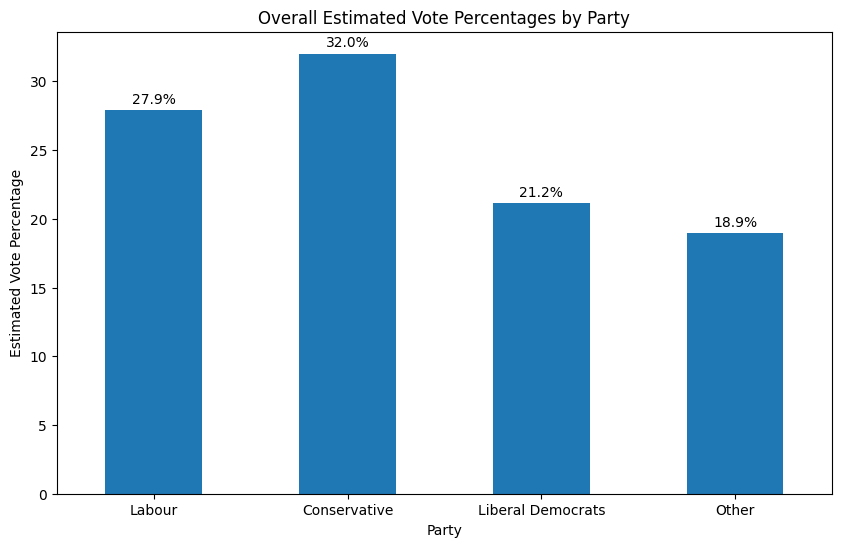

<Figure size 640x480 with 0 Axes>

In [21]:
# Aggregate data to calculate average estimated percentages for each party
overall_estimates = aggregated_data[['party_1_vote_percentage', 'party_2_vote_percentage', 'party_3_vote_percentage', 'party_4_vote_percentage']].mean()

# Plotting
overall_estimates.plot(kind='bar', figsize=(10, 6))
plt.title('Overall Estimated Vote Percentages by Party')
plt.xlabel('Party')
plt.ylabel('Estimated Vote Percentage')
plt.xticks(range(len(overall_estimates.index)), ['Labour', 'Conservative', 'Liberal Democrats', 'Other'], rotation='horizontal')
for i, v in enumerate(overall_estimates):
    plt.text(i, v + 0.5, str(round(v, 1)) + '%', ha='center')
plt.show()
plt.savefig('estimated_vote_percentages.png')

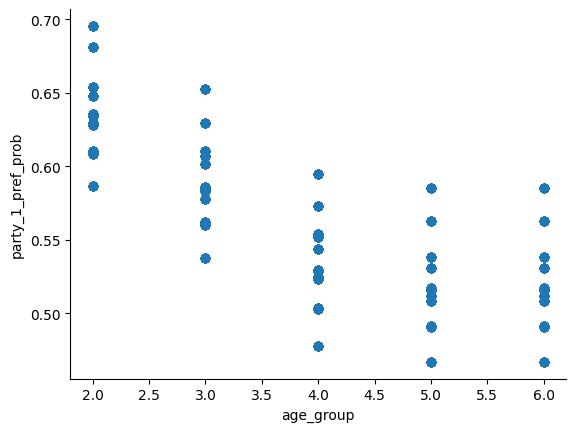

In [29]:
# @title education_level vs party_1_pref_prob
#convet to ridge plot
from matplotlib import pyplot as plt
aggregated_data.plot(kind='scatter', x='age_group', y='party_1_pref_prob', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##Scaling

In [33]:
file_path = '/Users/reedgarvin/Documents/GitHub/uk-2019-mrp/02_data/BES-2019-General-Election-results-file-v1.1.dta'
df_results = pd.read_stata(file_path)

#Remove Scotland
df_results_filtered = df_results[df_results['Country'] != 'Scotland']
df_results_filtered = df_results_filtered.drop(['SNP19', 'SNPVote19'], axis=1)

columns_to_retain = [
    'ONSConstID','Winner19',
    'Con19', 'Lab19', 'LD19', 'PC19', 'UKIP19', 'Green19', 'Brexit19', 'Other19',
    'ConVote19', 'LabVote19', 'LDVote19', 'PCVote19', 'UKIPVote19', 'GreenVote19', 'BrexitVote19',
    'TotalVote19', 'Electorate19'
]

df_results_filtered = df_results_filtered[columns_to_retain]
#df_results_filtered[columns_to_retain] = df_results_filtered[columns_to_retain].fillna(0)


# Convert vote share columns from float32 to a more precise datatype if necessary
vote_share_columns = ['Con19', 'Lab19', 'LD19', 'PC19', 'UKIP19', 'Green19', 'Brexit19', 'Other19',
    'ConVote19', 'LabVote19', 'LDVote19', 'PCVote19', 'UKIPVote19', 'GreenVote19', 'BrexitVote19',
    'TotalVote19', 'Electorate19']
df_results_filtered[vote_share_columns] = df_results_filtered[vote_share_columns].fillna(0)
df_results_filtered[vote_share_columns] = df_results_filtered[vote_share_columns].astype('int')



/var/folders/vv/n1q76g7d4f35zzj1q47755yh0000gn/T/ipykernel_85019/2284665910.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df_results = pd.read_stata(file_path)


In [34]:
# Renaming columns for clarity
rename_columns = {
    'Con19': 'Con_percent',
    'Lab19': 'Lab_percent',
    'LD19': 'LD_percent',
    'PC19': 'PC_percent',
    'UKIP19': 'UKIP_percent',
    'Green19': 'Green_percent',
    'ConVote19': 'ConVote',
    'LabVote19': 'LabVote',
    'LDVote19': 'LDVote',
    'PCVote19': 'PCVote',
    'UKIPVote19': 'UKIPVote',
    'GreenVote19': 'GreenVote',
    'TotalVote19': 'TotalVote'
}

df_results_filtered = df_results_filtered.rename(columns=rename_columns)

print(df_results_filtered.columns)


Index(['ONSConstID', 'Winner19', 'Con_percent', 'Lab_percent', 'LD_percent',
       'PC_percent', 'UKIP_percent', 'Green_percent', 'Brexit19', 'Other19',
       'ConVote', 'LabVote', 'LDVote', 'PCVote', 'UKIPVote', 'GreenVote',
       'BrexitVote19', 'TotalVote', 'Electorate19'],
      dtype='object')


In [35]:
# Summing up the vote counts for non-major parties into 'OtherVote' and 'Other_percent'
df_results_filtered['OtherVote'] = df_results_filtered['PCVote'] + df_results_filtered['UKIPVote'] + df_results_filtered['GreenVote']

# Calculating the percentage of votes for 'Other' category
df_results_filtered['Other_percent'] = 100 * df_results_filtered['OtherVote'] / df_results_filtered['TotalVote']

party_columns_mapping = {
    'Lab': 'party_1_vote_percentage',
    'Con': 'party_2_vote_percentage',
    'LD': 'party_3_vote_percentage',
    'Other': 'party_4_vote_percentage'
}
df_results_filtered.rename(columns={'ONSConstID': 'constit_code'}, inplace=True)

# Merge to combine actual percentages from 'true_results' into 'aggregated_with_true'
aggregated_with_true = pd.merge(aggregated_data, df_results_filtered, on='constit_code')

# Calculate scale factors based on actual/estimated percentages
parties = ['Lab', 'Con', 'LD', 'Other']
for party, col_name in party_columns_mapping.items():
    actual_col = f'{party}_percent'  # This should match columns in your actual data
    estimated_col = col_name  # Directly use the mapping
    scale_factor_col = f'{party}_scale_factor'  # New column for scale factor

    # Calculate scale factor as actual/estimated
    aggregated_with_true[estimated_col].replace(0, np.nan, inplace=True)  # Replace 0 with NaN to avoid division by zero
    aggregated_with_true[scale_factor_col] = aggregated_with_true[actual_col] / aggregated_with_true[estimated_col]

    # Optional: Handle infinite or NaN scale factors
    aggregated_with_true[scale_factor_col].replace([np.inf, -np.inf], np.nan, inplace=True)
    aggregated_with_true[scale_factor_col].fillna(1, inplace=True)  # Default scale factor for missing/infinite values

# Apply scale factors to the estimated percentages
for party, col_name in party_columns_mapping.items():
    scale_factor_col = f'{party}_scale_factor'
    scaled_col = f'{col_name}_scaled'  # New column for scaled estimates
    aggregated_with_true[scaled_col] = aggregated_with_true[col_name] * aggregated_with_true[scale_factor_col]

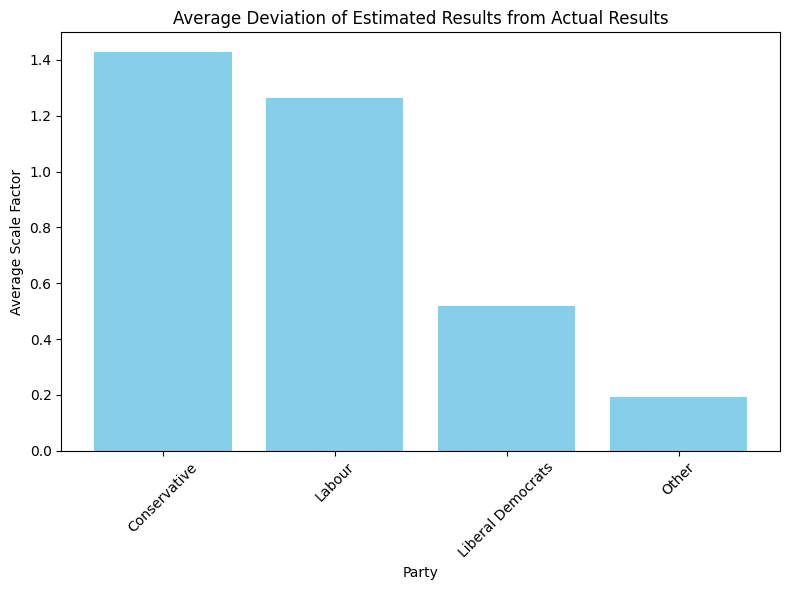

In [36]:
# Calculate the average scale factor for each party
average_scale_factors = aggregated_with_true[['Con_scale_factor', 'Lab_scale_factor', 'LD_scale_factor', 'Other_scale_factor']].mean()

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
parties = ['Conservative', 'Labour', 'Liberal Democrats', 'Other']
ax.bar(parties, average_scale_factors, color='skyblue')

# Adding labels and title
ax.set_xlabel('Party')
ax.set_ylabel('Average Scale Factor')
ax.set_title('Average Deviation of Estimated Results from Actual Results')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
